In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Rescaling
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

class_names = ['airplane', "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [50]:
y_train.shape

(50000, 1)

In [51]:
# y_train shape is (50000, 1) meaning each label is in an array of its own
# flatten the y arrays to be easier to work with
y_train = y_train.flatten()
y_test = y_test.flatten()

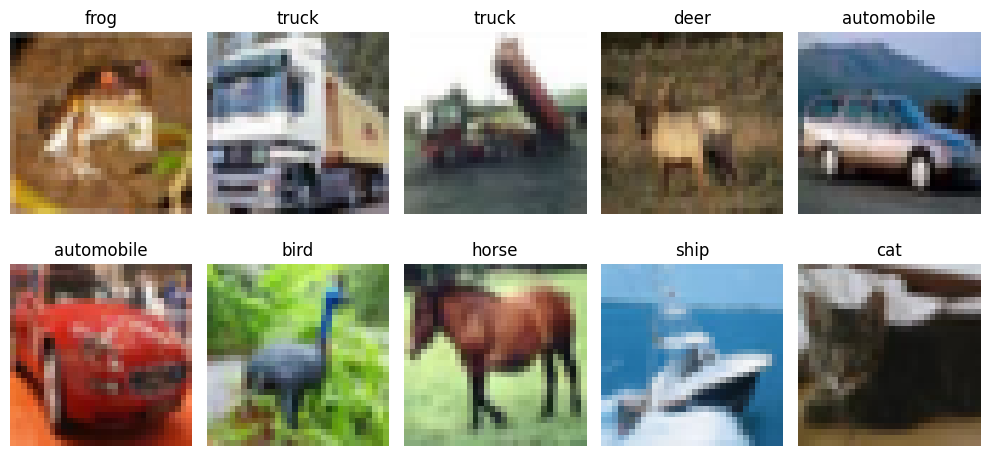

In [52]:
# visualise data points

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])   
    plt.axis('off')
plt.tight_layout()
plt.show()

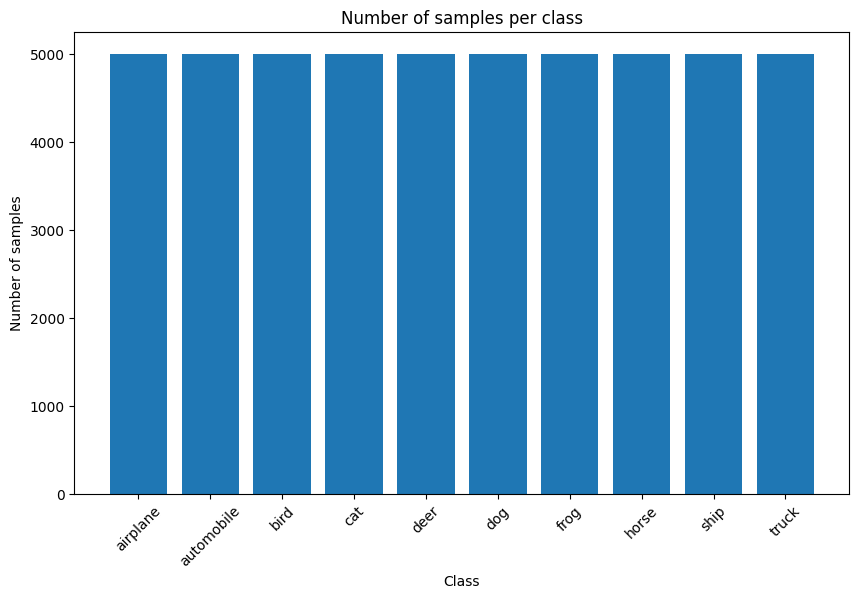

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [53]:
from collections import Counter

labels = y_train

# Count the number of samples per class
class_counts = Counter(labels)

# Sort by class index
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]


# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(rotation=45)
plt.show()

# Optional: print counts for reference
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")


In [54]:
# encode labels as one-hot vectors
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [55]:
X_train[0].shape

(32, 32, 3)

In [56]:
# make copies of the data before it gets processed for transfer learning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

y_train_cat_clean = y_train_cat.copy()
y_test_cat_clean = y_test_cat.copy()

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.activations import gelu
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


In [57]:
from keras.applications import NASNetMobile
from keras.applications.nasnet import preprocess_input

x_train_resized = tf.image.resize(X_train, (96, 96))
x_test_resized  = tf.image.resize(X_test,  (96, 96))

X_train = preprocess_input(x_train_resized)
X_test = preprocess_input(x_test_resized)

In [18]:
# build a transfer learning model from NASNetMobile
nasnet = NASNetMobile(input_shape=(96,96,3), include_top=False, weights="imagenet")

# freeze the pre-trained layers
nasnet.trainable = False 

In [19]:
# add custom layers on top

model_nasnet = models.Sequential([
    nasnet,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

model_nasnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 3, 3, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       270,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,542,878 (17.33 MB)

 Trainable params: 273,162 (1.04 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [20]:
model_nasnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_nasnet = model_nasnet.fit(
    X_train, 
    y_train_cat, 
    validation_split=0.2, 
    epochs=6, 
    batch_size=32)

Epoch 1/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 108ms/step - accuracy: 0.6914 - loss: 0.9361 - val_accuracy: 0.7546 - val_loss: 0.7195
Epoch 2/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 153ms/step - accuracy: 0.7501 - loss: 0.7327 - val_accuracy: 0.7624 - val_loss: 0.6805
Epoch 3/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 169s 136ms/step - accuracy: 0.7687 - loss: 0.6700 - val_accuracy: 0.7682 - val_loss: 0.6722
Epoch 4/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.7827 - loss: 0.6212 - val_accuracy: 0.7711 - val_loss: 0.6675
Epoch 5/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 174s 139ms/step - accuracy: 0.7949 - loss: 0.5801 - val_accuracy: 0.7705 - val_loss: 0.6816
Epoch 6/6
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 169s 135ms/step - accuracy: 0.8078 - loss: 0.5422 - val_accuracy: 0.7729 - val_loss: 0.6789


In [ ]:
# unfreeze the last 10 layers of NASNet for improved task orientedness
nasnet.trainable = True

fine_tune_at = len(nasnet.layers) - 10
for layer in nasnet.layers[:fine_tune_at]:
    layer.trainable = False

In [23]:
model_nasnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model_nasnet.fit(
    X_train, 
    y_train_cat,
    validation_split=0.2,
    epochs=12,
    initial_epoch=6,
    batch_size=32
)

Epoch 7/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.8310 - loss: 0.4740 - val_accuracy: 0.7759 - val_loss: 0.6758
Epoch 8/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8363 - loss: 0.4605 - val_accuracy: 0.7771 - val_loss: 0.6756
Epoch 9/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.8401 - loss: 0.4478 - val_accuracy: 0.7782 - val_loss: 0.6756
Epoch 10/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 110ms/step - accuracy: 0.8432 - loss: 0.4421 - val_accuracy: 0.7799 - val_loss: 0.6757
Epoch 11/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.8444 - loss: 0.4365 - val_accuracy: 0.7812 - val_loss: 0.6763
Epoch 12/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.8486 - loss: 0.4294 - val_accuracy: 0.7816 - val_loss: 0.6768


In [24]:
model_nasnet.save("TL_NASNet_Laura.keras")

# DenseNet

In [84]:
# restore clean variables

X_train = X_train_clean.copy()
X_test = X_test_clean.copy()

y_train_cat = y_train_cat_clean.copy()
y_test_cat = y_test_cat_clean.copy()

In [85]:
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input

x_train_resized = tf.image.resize(X_train, (96, 96))
x_test_resized  = tf.image.resize(X_test,  (96, 96))

X_train = preprocess_input(x_train_resized)
X_test = preprocess_input(x_test_resized)

In [86]:
dense_net = DenseNet121(input_shape=(96, 96, 3), include_top=False, weights="imagenet")
dense_net.trainable = False

In [87]:
model_densenet = Sequential([
    dense_net,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model_densenet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 3, 3, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [88]:
model_densenet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [89]:
history_densenet = model_densenet.fit(X_train, y_train_cat, validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 247s 192ms/step - accuracy: 0.8178 - loss: 0.5468 - val_accuracy: 0.8564 - val_loss: 0.4282
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 275s 220ms/step - accuracy: 0.8667 - loss: 0.3870 - val_accuracy: 0.8579 - val_loss: 0.4166
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 290s 232ms/step - accuracy: 0.8822 - loss: 0.3436 - val_accuracy: 0.8563 - val_loss: 0.4170
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 343s 274ms/step - accuracy: 0.8910 - loss: 0.3069 - val_accuracy: 0.8614 - val_loss: 0.4173
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 378s 303ms/step - accuracy: 0.9027 - loss: 0.2754 - val_accuracy: 0.8611 - val_loss: 0.4286


In [90]:
X_test.shape

TensorShape([10000, 96, 96, 3])

In [91]:
test_loss, test_acc = model_densenet.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 237ms/step - accuracy: 0.8507 - loss: 0.4497
Test Accuracy: 0.8507


In [92]:
# Predictions
y_pred_probs = model_densenet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 257ms/step


In [93]:
y_test_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], shape=(10000, 10))

In [94]:
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.91      0.85      0.88      1000
  automobile       0.86      0.93      0.90      1000
        bird       0.82      0.82      0.82      1000
         cat       0.73      0.76      0.75      1000
        deer       0.84      0.80      0.82      1000
         dog       0.79      0.81      0.80      1000
        frog       0.84      0.91      0.87      1000
       horse       0.90      0.85      0.88      1000
        ship       0.92      0.89      0.90      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



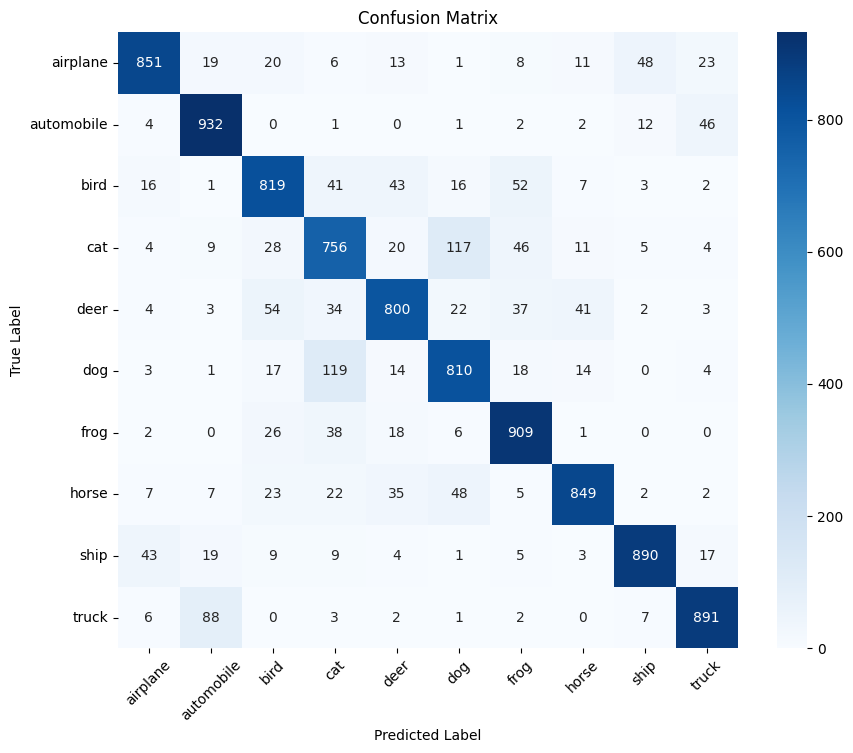

In [95]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [96]:
# Unfreeze last layers of base model for fine-tuning
dense_net.trainable = True

# Freeze all layers except the last N (e.g., last 20 layers)
fine_tune_at = len(dense_net.layers) - 20
for layer in dense_net.layers[:fine_tune_at]:
    layer.trainable = False

In [97]:
# Compile model with a lower learning rate
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 5
total_epochs = 3 + fine_tune_epochs  # if trained earlier 3 epochs

densenetfine = model_densenet.fit(
    X_train, 
    y_train_cat,
    validation_split=0.2,
    epochs=10,
    initial_epoch=5,        # start from a specific epoch from the previous training of the model
    batch_size=32
)


Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 401s 317ms/step - accuracy: 0.8802 - loss: 0.3493 - val_accuracy: 0.8634 - val_loss: 0.4044
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 394s 315ms/step - accuracy: 0.9032 - loss: 0.2830 - val_accuracy: 0.8683 - val_loss: 0.3902
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 401s 321ms/step - accuracy: 0.9068 - loss: 0.2672 - val_accuracy: 0.8712 - val_loss: 0.3826
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 425s 340ms/step - accuracy: 0.9116 - loss: 0.2567 - val_accuracy: 0.8736 - val_loss: 0.3777
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 395s 316ms/step - accuracy: 0.9150 - loss: 0.2495 - val_accuracy: 0.8740 - val_loss: 0.3739


In [99]:
densenetfine = model_densenet.fit(
    X_train, 
    y_train_cat,
    validation_split=0.2,
    epochs=15,
    initial_epoch=10,        # start from a specific epoch from the previous training of the model
    batch_size=32
)

Epoch 11/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 378s 303ms/step - accuracy: 0.9184 - loss: 0.2402 - val_accuracy: 0.8752 - val_loss: 0.3710
Epoch 12/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 386s 309ms/step - accuracy: 0.9184 - loss: 0.2356 - val_accuracy: 0.8759 - val_loss: 0.3690
Epoch 13/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 399s 319ms/step - accuracy: 0.9213 - loss: 0.2277 - val_accuracy: 0.8762 - val_loss: 0.3671
Epoch 14/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 388s 311ms/step - accuracy: 0.9252 - loss: 0.2200 - val_accuracy: 0.8770 - val_loss: 0.3649
Epoch 15/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 390s 312ms/step - accuracy: 0.9270 - loss: 0.2141 - val_accuracy: 0.8782 - val_loss: 0.3636


In [100]:
densenetfine = model_densenet.fit(
    X_train, 
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    initial_epoch=15,        # start from a specific epoch from the previous training of the model
    batch_size=32
)

Epoch 16/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 328s 262ms/step - accuracy: 0.9287 - loss: 0.2084 - val_accuracy: 0.8800 - val_loss: 0.3615
Epoch 17/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 399s 319ms/step - accuracy: 0.9288 - loss: 0.2050 - val_accuracy: 0.8802 - val_loss: 0.3601
Epoch 18/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 402s 322ms/step - accuracy: 0.9336 - loss: 0.1978 - val_accuracy: 0.8797 - val_loss: 0.3595
Epoch 19/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 347s 278ms/step - accuracy: 0.9332 - loss: 0.1950 - val_accuracy: 0.8801 - val_loss: 0.3581
Epoch 20/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 346s 276ms/step - accuracy: 0.9369 - loss: 0.1895 - val_accuracy: 0.8807 - val_loss: 0.3568


In [101]:
test_loss, test_acc = model_densenet.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.8739 - loss: 0.3760
Test Accuracy: 0.8739


In [102]:
# Predictions
y_pred_probs = model_densenet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step


In [103]:
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.89      0.90      0.89      1000
  automobile       0.91      0.93      0.92      1000
        bird       0.86      0.84      0.85      1000
         cat       0.78      0.78      0.78      1000
        deer       0.81      0.86      0.83      1000
         dog       0.85      0.81      0.83      1000
        frog       0.90      0.91      0.90      1000
       horse       0.91      0.89      0.90      1000
        ship       0.92      0.92      0.92      1000
       truck       0.91      0.92      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



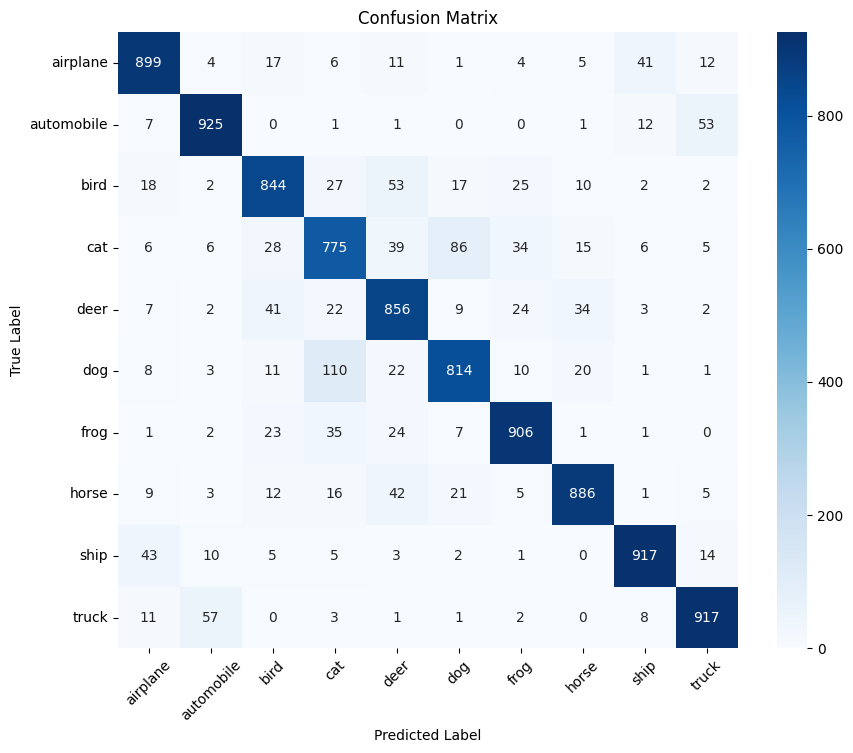

In [104]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [105]:
model_densenet.save("TL_DenseNet_Laura.keras")